**IMPORTING LIBRARIES**

In [34]:
!pip install Augmentor
import Augmentor 
import os, glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt

**MOUNTING DRIVE**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def unzipping_dataset():
  !unzip 'gdrive/My Drive/dataset/trainingbenign.zip'
  !unzip 'gdrive/My Drive/dataset/trainingmalign.zip'
  !unzip 'gdrive/My Drive/dataset/testbenign.zip'
  !unzip 'gdrive/My Drive/dataset/testmalign.zip'

**UNZIPPING DATASET** 

In [4]:
unzipping_dataset()

Archive:  gdrive/My Drive/dataset/trainingbenign.zip
  inflating: trainingbenign/us1.bmp  
  inflating: trainingbenign/us11.bmp  
  inflating: trainingbenign/us12.bmp  
  inflating: trainingbenign/us13.bmp  
  inflating: trainingbenign/us14.bmp  
  inflating: trainingbenign/us16.bmp  
  inflating: trainingbenign/us17.bmp  
  inflating: trainingbenign/us18.bmp  
  inflating: trainingbenign/us19.bmp  
  inflating: trainingbenign/us2.bmp  
  inflating: trainingbenign/us21.bmp  
  inflating: trainingbenign/us22.bmp  
  inflating: trainingbenign/us23.bmp  
  inflating: trainingbenign/us24.bmp  
  inflating: trainingbenign/us26.bmp  
  inflating: trainingbenign/us27.bmp  
  inflating: trainingbenign/us28.bmp  
  inflating: trainingbenign/us29.bmp  
  inflating: trainingbenign/us3.bmp  
  inflating: trainingbenign/us31.bmp  
  inflating: trainingbenign/us32.bmp  
  inflating: trainingbenign/us33.bmp  
  inflating: trainingbenign/us34.bmp  
  inflating: trainingbenign/us36.bmp  
  inflating: t

**DATA** **AUGMENTATION**

In [5]:
# By default these will be written to the disk in a directory named 
# output relative to the path specified when initialising the p pipeline object above.

def augmenting_benign(path):
  p = Augmentor.Pipeline(path) 
  p.flip_left_right(0.5) 
  #p.black_and_white(0.1) 
  p.rotate(0.3, 10, 10) 
  p.skew(0.4, 0.5) 
  p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5) 
  p.sample(500) 

def augmenting_malignant(path):
  p = Augmentor.Pipeline(path) 
  p.flip_left_right(0.5) 
  #p.black_and_white(0.1) 
  p.rotate(0.3, 10, 10) 
  p.skew(0.4, 0.5) 
  p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5) 
  p.sample(750) 

In [6]:
augmenting_benign ('trainingbenign')
augmenting_malignant ('trainingmalign')

Processing <PIL.BmpImagePlugin.BmpImageFile image mode=L size=157x105 at 0x7F277A5B56D8>:   2%|▏         | 11/500 [00:00<00:05, 87.43 Samples/s]

Initialised with 80 image(s) found.
Output directory set to trainingbenign/output.

Processing <PIL.Image.Image image mode=L size=95x69 at 0x7F2774CD89B0>: 100%|██████████| 500/500 [00:01<00:00, 394.38 Samples/s]
Processing <PIL.Image.Image image mode=L size=119x91 at 0x7F2774D33710>:   0%|          | 3/750 [00:00<02:20,  5.30 Samples/s]                

Initialised with 120 image(s) found.
Output directory set to trainingmalign/output.

Processing <PIL.Image.Image image mode=L size=183x147 at 0x7F2774D09B70>: 100%|██████████| 750/750 [00:02<00:00, 309.13 Samples/s]


**FORMING TRAINING DATA**

In [7]:
def enumerating (path):
  images=[]
  filelist = sorted(glob.glob(os.path.join(path, '*.bmp')))
  for j, imagepath in enumerate(filelist):
    img1 = cv2.imread(filelist[j])
    img1 = cv2.resize(img1, (44, 44), interpolation=cv2.INTER_LINEAR)
    images.append(img1)
  return images

def form_training_data (b_path, b_path_aug, m_path, m_path_aug):
  images=[]
  imgs = enumerating (b_path)
  images.extend (imgs)
  imgs = enumerating (b_path_aug)
  images.extend (imgs)
  print (len(images))
  imgs = enumerating (m_path)
  images.extend (imgs)
  imgs = enumerating (m_path_aug)
  images.extend (imgs)
  print (len(images))
  return images

In [8]:
images = form_training_data ('trainingbenign','trainingbenign/output','trainingmalign','trainingmalign/output')
images = np.stack (images,axis = 0)

580
1450


In [9]:
images.shape

(1450, 44, 44, 3)

In [10]:
print (len(images))

1450


**LABEL TO THE TRAINING IMAGES**

In [11]:
labels = []
for i in range (len(images)):
  if (i<580):
    labels.append (0)     #0 label for benign lesions
  else:
    labels.append (1)     #1 label for malignant lesions

labels = np.reshape (np.stack(labels, axis = 0), (1450,1))

In [12]:
labels.shape

(1450, 1)

**TRAIN-TEST DATA SPLITTING**

In [13]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42) 

In [14]:
# Normalize pixel values to be between 0 and 1
train_images, val_images = train_images / 255.0, val_images / 255.0

**CREATING MODEL**

In [15]:
def create_model():
  model = Sequential()
  model.add(Convolution2D(32, (3, 3), padding = 'same', activation='relu', input_shape=(44,44,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, (3, 3), padding ='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.25))
  model.add(Convolution2D(128, (3, 3),padding = 'same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(64, activation='tanh'))
  # model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  return model

In [16]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 128)         0

**COMPILING MODEL**

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(val_images, val_labels))

Epoch 1/20
37/37 [==============================] - 0s 10ms/step - loss: 0.6861 - accuracy: 0.5698 - val_loss: 0.6585 - val_accuracy: 0.6069
Epoch 2/20
37/37 [==============================] - 0s 4ms/step - loss: 0.5868 - accuracy: 0.6957 - val_loss: 0.4591 - val_accuracy: 0.7931
Epoch 3/20
37/37 [==============================] - 0s 5ms/step - loss: 0.4607 - accuracy: 0.7957 - val_loss: 0.3817 - val_accuracy: 0.8172
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 0.3681 - accuracy: 0.8466 - val_loss: 0.4485 - val_accuracy: 0.7862
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 0.3012 - accuracy: 0.8681 - val_loss: 0.2936 - val_accuracy: 0.8862
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 0.2604 - accuracy: 0.9000 - val_loss: 0.2634 - val_accuracy: 0.8828
Epoch 7/20
37/37 [==============================] - 0s 4ms/step - loss: 0.2327 - accuracy: 0.9078 - val_loss: 0.2500 - val_accuracy: 0.9138
Epoch 8/20
37/37 [=

**SAVING MODEL**

In [18]:
model.save('gdrive/My Drive/classification_model/model.h5')

**PLOTTING HISTORY**

In [19]:
def plot(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')

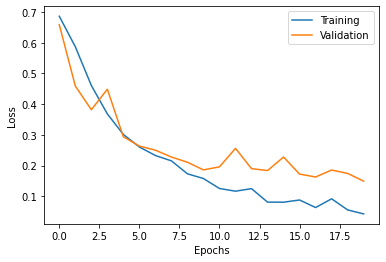

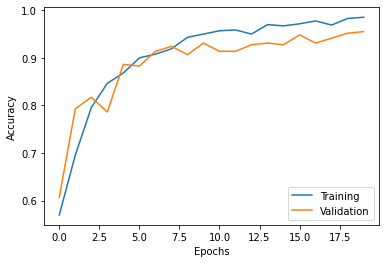

In [20]:
plot (history)

**LOADING SAVED MODEL**

In [21]:
model_path = "gdrive/My Drive/classification_model/model.h5"
model = tf.keras.models.load_model(model_path)

**PREDICTION ON TEST IMAGES**

In [22]:
def pred (image):
  data = []
  data.append(image)
  X_test = np.array(data)
  X_test = X_test.astype('float32')/255 
  pred = model.predict_classes(X_test)
  return pred[0]  

In [23]:
## PREDICTION ON TEST BENIGN

filelist = sorted(glob.glob(os.path.join('testbenign', '*.bmp')))
t_benign = []
for j, imagepath in enumerate(filelist):
  img1 = cv2.imread(filelist[j])
  img1 = cv2.resize(img1, (44, 44), interpolation=cv2.INTER_LINEAR)
  label = pred (np.array (img1))
  t_benign.append (label)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [24]:
print (t_benign)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
## PREDICTION ON TEST MALIGNANT

filelist = sorted(glob.glob(os.path.join('testmalign', '*.bmp')))
t_malignant = []
for j, imagepath in enumerate(filelist):
  img1 = cv2.imread(filelist[j])
  img1 = cv2.resize(img1, (44, 44), interpolation=cv2.INTER_LINEAR)
  label = pred (np.array (img1))
  t_malignant.append (label)

In [26]:
print (t_malignant)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**RED ATTACK**

DIFFERENCE BETWEEN 2 IMAGES

In [27]:
def max_diff(img1,img2):
    img = img1 - img2
    return np.amax(img)

BOUNDARY ESTIMATION

In [28]:
def boundary_estimation(source, target, dmin):
    Ii = ((source + target)/2.0)
    k = pred(Ii)
    delta = max_diff(source, Ii)
    Ia2 = source
    Ib2 = target
    p = Ib2
    while (delta > dmin):
        if (pred(Ia2) != k):
            Ib2 = Ii
        else:
            Ia2 = Ii
        Ii = ((Ia2+Ib2)/2.0)
        k = pred(Ii)
        delta = max_diff(Ia2,Ii)  
    return Ii

In [29]:
img = cv2.imread ('testbenign/us100.bmp')
source_img = np.array (cv2.resize (img,(44,44), interpolation=cv2.INTER_LINEAR))

img = cv2.imread ('testmalign/us105.bmp')
target_img = np.array (cv2.resize (img,(44,44), interpolation=cv2.INTER_LINEAR))  

In [30]:
print ("source image class: ",pred (source_img))
print ("target image class: ",pred (target_img))
adv_img = boundary_estimation (source_img,target_img, 1.0)
print ("adversarial image class: ",pred(adv_img))


source image class:  0
target image class:  1
adversarial image class:  1


GO OUT FUNCTION

In [31]:
def go_out(source,iout,alpha):
    i_diff = iout - source
    pred_source = pred(source)
    inew = iout
    while (pred(inew)==pred(source)):
        inew = inew + alpha*(i_diff)
        
    return inew

In [32]:
out_img = go_out (source_img, adv_img, 0.01)
print ("out image class: ",pred (out_img))

out image class:  1


In [35]:
from PIL import Image

Image.fromarray(source_img.astype('uint8')).save ('source_image.png')
Image.fromarray(target_img.astype('uint8')).save ('target_image.png')
Image.fromarray(adv_img.astype('uint8')).save ('adv_image.png')
Image.fromarray(out_img.astype('uint8')).save ('out_image.png')

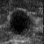

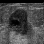

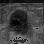

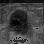

In [36]:
from IPython.display import Image,display

display(Image("source_image.png", width=200, height=200))
print()
display(Image("target_image.png", width=200, height=200))
print ()
display(Image("adv_image.png", width=200, height=200))
print ()
display(Image("out_image.png", width=200, height=200))

GRADIENT ESTIMATION

In [37]:
def array_diff(d1):
    sumd1 = 0.0
    for i in range(0,3):
        for j in range(0,44):
            for k in range(0,44):
                d1[j][k][i] = d1[j][k][i]*d1[j][k][i]
                sumd1 = sumd1 + d1[j][k][i]
    return (sumd1)

def gradient_estimation(source, target, adversarial, n, theta):
    Ia = source
    Ib = target
    Ii = adversarial
    Io = np.zeros((5808))
    X = np.random.randint(0,5808, size=n)
    for i in X:
        Io[i] = 255
    Io = Io.reshape((44,44,3))
#     print(Io*theta)
    Ii2 = Ii + theta*Io
    Ii2_new = boundary_estimation(Ia, Ii2, 1.0)
    Ii2_new = go_out(source,Ii2_new,0.01)
    diff2 = Ii2_new - Ia
    diff1 = Ii - Ia
    d2 = array_diff(diff2)
    d1 = array_diff(diff1)
    if (d2 > d1):
        return (-1, Ii2_new)
    elif (d1 > d2):
        return (1, Ii2_new)
    else:
        return (0,Ii2_new)

EFFICIENT UPDATE

In [38]:
def efficient_update(source, target, adversarial, I2, g, j):
    Ia = source
    Ib = target
    Ii = adversarial
    Ii2 = I2
    delta = g*(Ii2 - Ii)
    l = j
    Inew = Ii + l*delta
    
    diff1 = Inew - Ia
    diff2 = Ii - Ia
    d1 = array_diff(diff1)
    d2 = array_diff(diff2)
    ii = 0
    it = 0
    while(d1 > d2):
        l = (l/2.0)
        Inew = Ii + l*delta
        if(pred(Inew)==pred(source)):
            Inew = go_out(source,Inew,0.01)
        it = it + 1
        d1 = array_diff(Inew-Ia)
        if(it>100):
            break
    if (d1 > d2):
        print(ii)
        ii = ii + 1
        Inew = Ii
    return Inew

ITERATION OVER THE IMAGE

In [39]:
def iteration(itr, source, target, n, theta, j, dmin):
    targett = target
    sourcee = source
    for i in range(itr):
        #print (i)
        adversarial_image = boundary_estimation(sourcee, targett, dmin)
        adversarial_image = go_out(sourcee,adversarial_image,0.01)
        (g, Iii2) = gradient_estimation(sourcee, targett, targett, n, theta)
        targett = efficient_update(sourcee, targett, adversarial_image, Iii2, g, j)
        if (pred(targett) == pred(source)):
            j = j/2.0
        fin = targett
        if(pred(targett)==pred(sourcee)):
            fin = go_out(sourcee,targett,0.01)
        if(array_diff(fin-sourcee)<array_diff(adversarial_image-sourcee)):
            targett = fin
            #print("uopp")
    
    return fin

In [45]:
perturbed_img = iteration(10,source_img,out_img,5,0.196,5.0,1.0)

In [46]:
print ("Perturbed image class: ", pred (perturbed_img))

Perturbed image class:  1


In [47]:
from PIL import Image
Image.fromarray(perturbed_img.astype('uint8')).save ('perturbed_image.png')

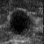

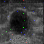

In [48]:
from IPython.display import Image,display
display(Image("source_image.png", width=200, height=200))
print()
display(Image("perturbed_image.png", width=200, height=200))

In [49]:
original = cv2.imread("source_image.png")
perturb = cv2.imread("perturbed_image.png")
from skimage import measure
s = measure.compare_ssim(original,perturb,multichannel=True)
print(s)

0.8061494514870094


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
